In [ ]:
# 모듈세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from functools import reduce # 데이터 병합용
# 전처리
from scipy import interpolate
import missingno as msno
# KNN imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 샘플링
from sklearn.model_selection import train_test_split

# 분류기
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#측정
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
1#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/전주시 데이터분석/data/'
# 예보, 관측
fcst = pd.read_csv(path + 'ulsan_fcst_data.csv')
obsn = pd.read_csv(path + 'ulsan_obs_data.csv')
# 일사
ilsa = pd.read_csv(path + 'pohang_ilsa.csv')
# 미세먼지
mise = pd.read_csv(path + 'ulsan_mise.csv', index_col = 0)
# 강수량
rain = pd.read_csv(path + 'ulsan_rain.csv')

## 1-1 데이터 정리

In [ ]:
def preprocessing(obsn, ilsa, mise, rain):

  # 관측 데이터 칼럼 이름 영문 변경
  obsn.drop(['지점','지점명'], axis=1,inplace=True)
  obsn.rename(columns = {'일시':'time','기온(°C)':'temp','풍속(m/s)':'windsp','풍향(16방위)':'winddir','전운량(10분위)':'cloud','습도(%)':'humid'}, inplace = True)
  obsn['time'] = pd.to_datetime(obsn['time'])

  obsn['temp'].interpolate(method='polynomial', order=2,inplace=True) 
  obsn['windsp'].interpolate(method='polynomial', order=2,inplace=True) 
  obsn['winddir'].interpolate(method='polynomial', order=2,inplace=True) 
  obsn['humid'].interpolate(method='polynomial', order=2,inplace=True) 

  # 일사 데이터
  #ilsa = ilsa.iloc[:,:25631] # 2월달 데이터 드랍
  ilsa.drop(['지점','지점명','일조 QC플래그'], axis=1, inplace=True)
  ilsa.rename(columns={'일시':'time','일조(hr)':'sun_hr','일사(MJ/m2)':'solar'}, inplace=True)
  ilsa['time']=pd.to_datetime(ilsa['time'])
  ilsa= ilsa.fillna(0)

  # 미세먼지 데이터
  mise.drop(['시도','측정소명','측정소코드'], axis=1, inplace=True)
  mise.rename(columns= {'날짜':'time','아황산가스':'so2', '일산화탄소':'co',  '오존': 'ozone', '이산화질소':'no2','PM10':'pm10','PM2.5':'pm2.5'},inplace=True)
  mise['time']=pd.to_datetime(mise['time'])
  
  # 강수량
  rain.drop(['지점'],axis=1, inplace=True)
  rain.rename(columns= {'날짜':'time', '강수량(mm)':'rn'},inplace=True)

  # interpolate imputation
  rain['time'] = pd.to_datetime(rain['time'])
  rain['rn'] = rain['rn'].fillna(0)
  rain = rain.set_index('time')
  rain = rain.resample('H').mean().interpolate()
  
  rain.reset_index(inplace=True)


  return obsn, ilsa, mise, rain
obsn, ilsa, mise, rain = preprocessing(obsn, ilsa, mise, rain)

In [ ]:
#1월달 미세먼지, 초미세먼지 전처리
def mise_pm(file_name, pm):
  df=pd.read_csv(path+f'{file_name}', sep='\t', header=None)
  df_values=df.values
  #type(df_values)
  datalist=[]
  datalist.append(df_values) #리스트로 변경
  df_array=np.array(datalist)
  df2=df_array.reshape(1,744)

  df3=pd.DataFrame(df2.T)
  df3['time']=pd.date_range(start='2021-01-01 01:00:00', end='2021-02-01 00:00:00', freq='H')
  df3=df3.rename(columns={0:f'{pm}'})
  return df3

ulsan_mise_pm25=mise_pm('ulsan_pm25.txt', 'pm2.5')
ulsan_mise_pm10=mise_pm('ulsan_pm10.txt', 'pm10')
ulsan_mise = pd.merge(ulsan_mise_pm25, ulsan_mise_pm10, on='time')
df=pd.concat([mise, ulsan_mise])
df.reset_index(drop=True)

mise = df.iloc[:25608, :]

In [ ]:
# ulsan_ilsa.head(20) 20:00~6:00 줄 누락
# 누락된 줄 채우기
# ulsan_ilsa['time']=pd.to_datetime(ulsan_ilsa['time'])
# time_df = pd.DataFrame()
# time_df['time'] = pd.date_range(start='2018-03-01 00:00:00', end='2021-02-28 23:00:00', freq='H')
# ulsan_ilsa = pd.merge(time_df, ulsan_ilsa, on='time', how='outer')

## 1-2 데이터 병합

In [ ]:
def frame(obsn, ilsa, mise, rain):
  frames = [obsn, ilsa, mise, rain]
  #all_obs = reduce(lambda  left,right: pd.merge(left , right, left_index=True, right_index=True, how='outer'), frames)  # merge
  #all_obs = reduce(lambda  left,right: pd.merge(left,right,on=['time'], how='outer'), frames)
  all_obs = pd.merge(obsn, ilsa, how='outer', on='time')
  all_obs = pd.merge(all_obs, mise, how='outer', on='time')
  all_obs = pd.merge(all_obs, rain, how='outer', on='time')

  all_obs.rename(columns = {'기온(°C)':'temp'}, inplace=True)

  all_obs['rn'] = all_obs['rn'].fillna(0)

  all_obs = all_obs.iloc[:25632,:]

  return all_obs
all_obs = frame(obsn, ilsa, mise, rain)

In [ ]:
all_obs['pm2.5'] = all_obs['pm2.5'].apply(lambda x: np.nan if isinstance(x, str) else x)
all_obs['pm10'] = all_obs['pm10'].apply(lambda x: np.nan if isinstance(x, str) else x)

In [ ]:
all_obs['pm10']

0         NaN
1        17.0
2         NaN
3         NaN
4         NaN
         ... 
25627    30.0
25628    32.0
25629    40.0
25630    41.0
25631    45.0
Name: pm10, Length: 25632, dtype: float64

In [ ]:
all_obs.shape

(25632, 19)

In [ ]:
all_obs.columns

Index(['time', 'temp', 'windsp', 'winddir', 'humid', 'cloud', 'sun_hr',
       'solar', 'so2', 'co', 'ozone', 'no2', 'pm2.5', 'pm10', 'rn', 'month',
       'season', 'hour', 'day'],
      dtype='object')

# 2 변수 생성 및 변환 작업 (순서 바꾸기)
- 월별
- 계절별
  - 봄: 3, 4, 5
  - 여름: 6, 7, 8
  - 가을: 9, 10, 11
  - 겨울: 12, 1, 2
- 강수량 qcut

In [ ]:
all_obs['time'] = pd.to_datetime(all_obs['time'])
# 월 변수 생성
all_obs['month'] = all_obs['time'].dt.month
# 계절 변수 생성 계절 변수 생성
all_obs['season'] = ((all_obs['month'] % 12)+3)//3
#obs.groupby('season')[['month']].describe()
# 1: 겨울 | 2: 봄 | 3: 여름 | 4: 가을
all_obs['hour'] = all_obs['time'].dt.hour
all_obs['day'] = all_obs['time'].dt.day

In [ ]:
# # 강수량
# #1. na -> 0로 채워주기
# all_obs['rn'] = all_obs['rn'].fillna(0)

# # 2. 0보다 큰 구간 조사
# pd.qcut(all_obs.rn[all_obs['rn']>0],q=5) 

# # 3. 2번에서 구한 구간으로 bins 설정
# bins = [0.099, 0.6, 2.4, 8.02, 21.98, 173.1] # [(0.099, 0.6] < (0.6, 2.4] < (2.4, 8.02] < (8.02, 21.98] < (21.98, 173.1]]
# labels = [0,1,2,3,4]
# all_obs['rn'] = pd.cut(all_obs['rn'], bins, labels=labels)

# 3 결측치 확인

In [ ]:
all_obs.isnull().sum()

time          0
temp          0
windsp        0
winddir       0
humid         0
cloud       825
sun_hr        0
solar         0
so2        1318
co         1845
ozone      1365
no2        1456
pm2.5      1069
pm10        889
rn            0
month         0
season        0
hour          0
day           0
dtype: int64

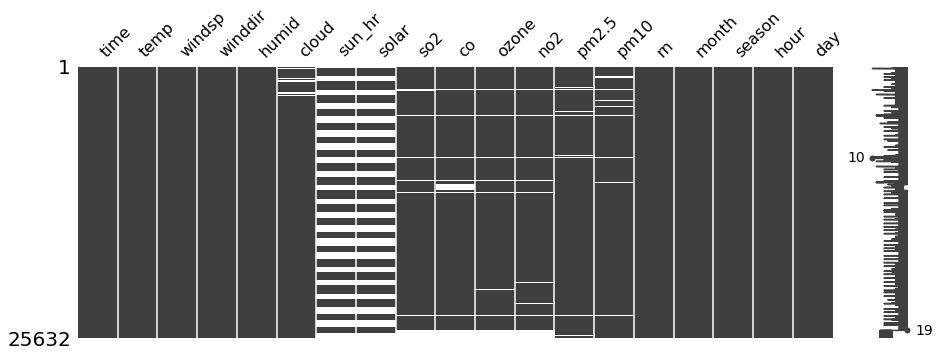

In [ ]:
msno.matrix(all_obs, figsize=(15,5))

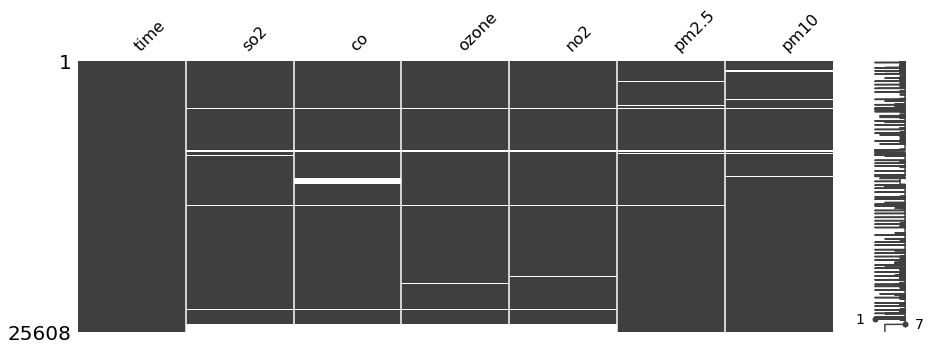

In [ ]:
msno.matrix(mise, figsize=(15,5))

In [ ]:
all_obs[:999].plot(figsize=(15,5))

In [ ]:
# print(all_obs[all_obs['cloud'].isnull()]) # 825 
# print(all_obs[all_obs['so2'].isnull()])   # 2059 
# print(all_obs[all_obs['co'].isnull()])    # 2586 
# print(all_obs[all_obs['ozone'].isnull()]) # 2106 
# print(all_obs[all_obs['no2'].isnull()])   # 2197
# print(all_obs[all_obs['pm10'].isnull()])  # 2217 
# print(all_obs[all_obs['pm25'].isnull()])  # 2322 흠.....

#### - all_obs.csv 저장

In [ ]:
all_obs.to_csv('/content/drive/MyDrive/전주시 데이터분석/울산/ulsan_all_obs.csv')

# 4 결측치 채우기
- !!! 채우기 전에 test train data 나누기 !!! : testing data를 inpute하면 안됨
- KNN
- 회귀 (아직안함)
- interpolate

- 참고: splitting data for time series data

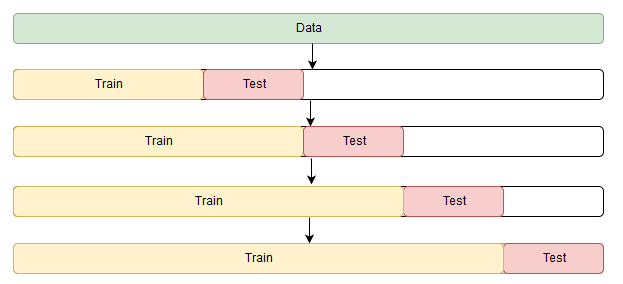

## 4_2 KNN imputation

In [ ]:
pip install impyute
from impyute.imputation.cs import fast_knn

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
all_obs.columns

Index(['time', 'temp', 'windsp', 'winddir', 'humid', 'cloud', 'sun_hr',
       'solar', 'so2', 'co', 'ozone', 'no2', 'pm2.5', 'pm10', 'rn', 'month',
       'season'],
      dtype='object')

In [ ]:
# 표준화
StdScale = StandardScaler().fit(all_obs[['temp','windsp',	'winddir','humid', 'so2',	'ozone', 	'no2',	'pm2.5',	'pm10', 'cloud', 'month', 'rn', 'co', 'sun_hr', 'solar']])
std_scaled = scale.transform(all_obs[['temp','windsp',	'winddir','humid', 'so2',	'ozone', 	'no2',	'pm2.5',	'pm10', 'cloud', 'month', 'rn', 'co', 'sun_hr', 'solar']])

In [ ]:
# 표준화
StdScale = StandardScaler().fit(all_obs[['so2',	'ozone', 	'no2',	'pm2.5',	'pm10']])
std_scaled = StdScale.transform(all_obs[['so2',	'ozone', 	'no2',	'pm2.5',	'pm10']])

In [ ]:
imputer = KNNImputer(n_neighbors=15)
std_filled = imputer.fit_transform(std_scaled)

In [ ]:
std_filled = pd.DataFrame(std_filled)
std_filled = std_filled.rename(columns={0:'temp',1:'windsp',2:'winddir', 3:'humid', 4:'so2', 5:'ozone',	6:'no2',	7:'pm25',	8:'pm10', 9:'cloud', 10:'month', 11:'rn', 12:'co', 13:'sun_hr', 14:'solar'})
std_filled = pd.concat([all_obs[['time']], std_filled], axis=1, join="inner")

In [ ]:
std_filled = pd.DataFrame(std_filled)
std_filled = std_filled.rename(columns={0:'so2',1:'ozone',2:'no2', 3:'pm2.5', 4:'pm10'})
std_filled = pd.concat([all_obs[['time','temp','windsp',	'winddir','humid','month', 'rn', 'co', 'sun_hr', 'solar','day','hour']], std_filled], axis=1, join="inner")

In [ ]:
# 정규화
MMscale = MinMaxScaler()
MM_scaled = scaler.fit_transform(all_obs[['temp','windsp',	'winddir','humid', 'so2',	'ozone', 	'no2',	'pm2.5',	'pm10', 'cloud', 'month', 'rn', 'co', 'sun_hr', 'solar']])

In [ ]:
imputer = KNNImputer(n_neighbors=15)
mm_filled = imputer.fit_transform(MM_scaled)

In [ ]:
mm_filled = pd.DataFrame(mm_filled)
mm_filled = filled3.rename(columns={0:'temp',1:'windsp',2:'winddir', 3:'humid', 4:'so2', 5:'ozone',	6:'no2',	7:'pm25',	8:'pm10', 9:'cloud', 10:'month', 11:'rn', 12:'co', 13:'sun_hr', 14:'solar'})
mm_filled = pd.concat([all_obs[['time']], mm_filled], axis=1, join="inner")

In [ ]:
# fast_knn
# np_imputed = fast_knn(all_obs[['temp','windsp',	'winddir','humid', 'so2',	'co',	'ozone',	'no2',	'PM2.5',	'PM10' 'cloud']].values, k=15, normalize="std")  # knn 학습

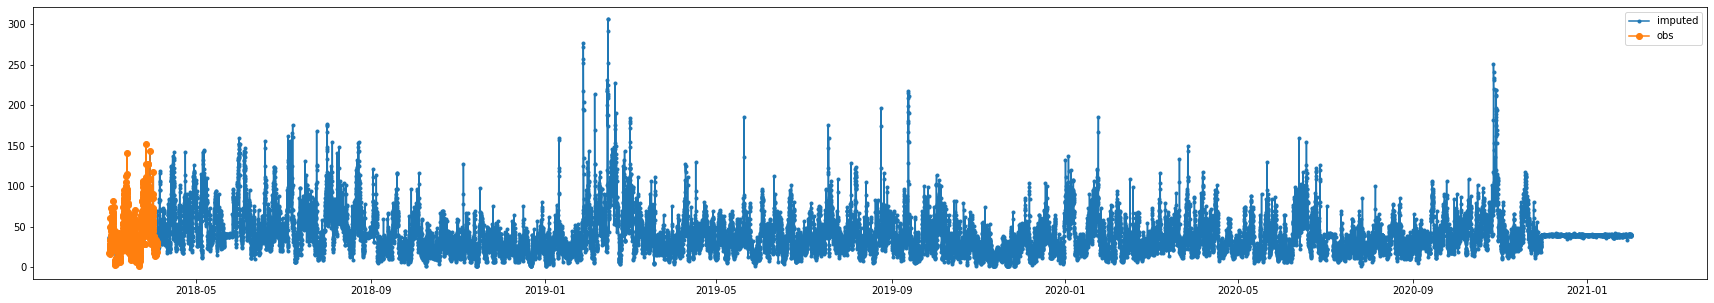

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(obs_imputed['Time'], obs_imputed['pm10'], '.-')
plt.plot(all_obs.loc[:800, 'Time'], all_obs.loc[:800, 'pm10'], '-o')
plt.legend(['imputed','obs'])

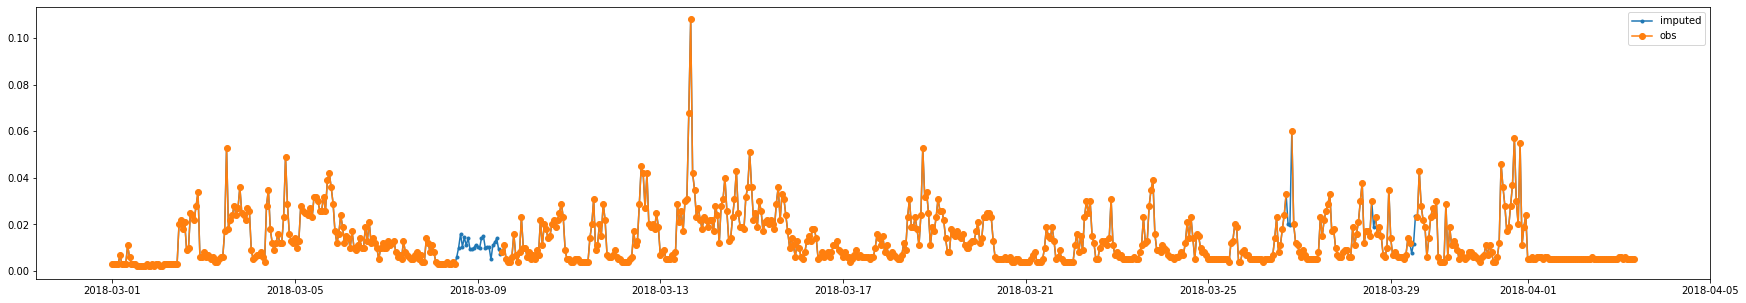

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(obs_imputed['Time'], obs_imputed['so2'], '.-')
plt.plot(all_obs.loc[:800, 'Time'], all_obs.loc[:800, 'so2'], '-o')
plt.legend(['imputed','obs'])

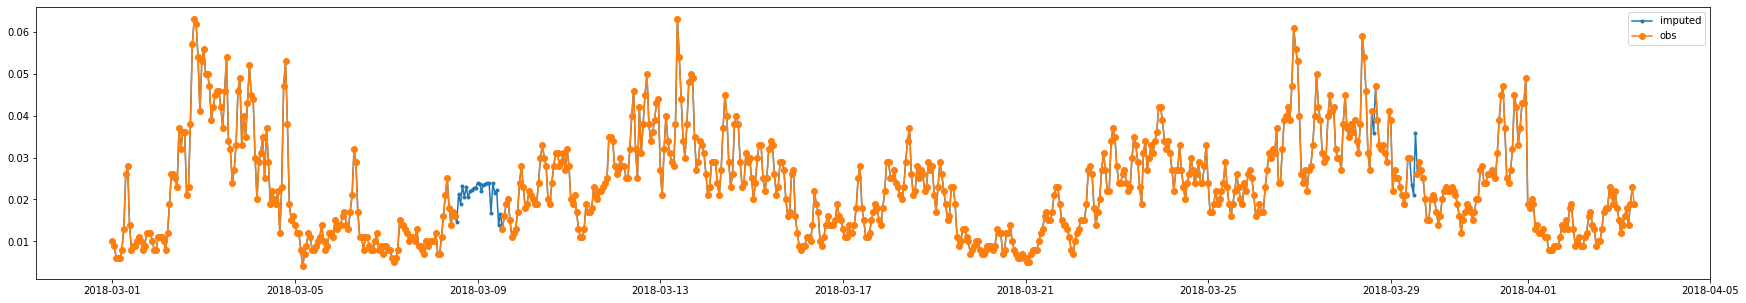

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(obs_imputed['Time'], obs_imputed['no2'], '.-')
plt.plot(all_obs.loc[:800, 'Time'], all_obs.loc[:800, 'no2'], '-o')
plt.legend(['imputed','obs'])

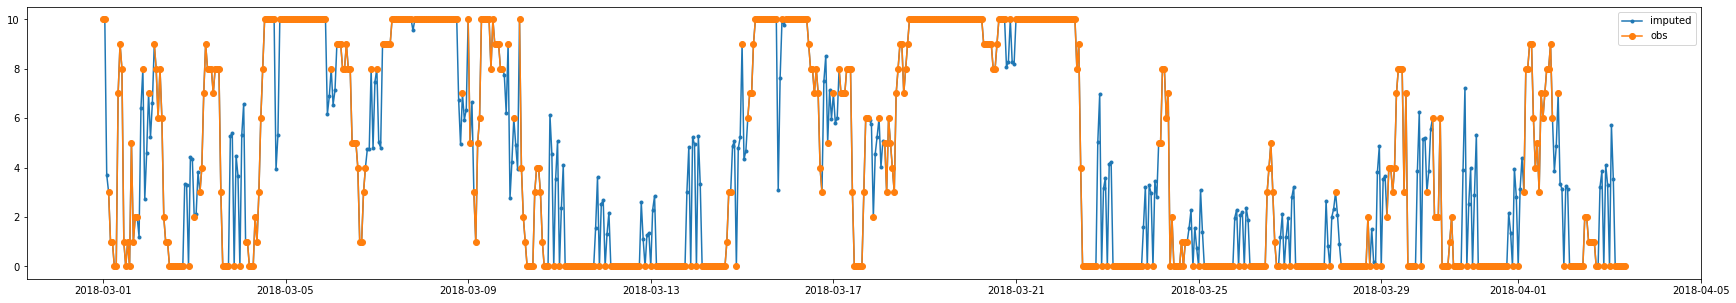

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(obs_imputed['Time'], obs_imputed['cloud'], '.-')
plt.plot(all_obs.loc[:800, 'Time'], all_obs.loc[:800, 'cloud'], '-o')
plt.legend(['imputed','obs'])

In [ ]:
std_filled.isnull().sum()

time          0
temp          0
windsp        0
winddir       0
humid         0
month         0
rn            0
co         1845
sun_hr        0
solar         0
so2           0
ozone         0
no2           0
pm2.5         0
pm10          0
dtype: int64

In [ ]:
# 더미화 작업

In [ ]:
# season_dummy = pd.get_dummies(all_obs['season'])
# all_obs=all_obs.join(season_dummy.add_prefix('season_'))

In [ ]:
print(all_obs.columns)
print(len(all_obs.columns))

Index(['Time', 'temp', 'windsp', 'winddir', 'humid', 'cloud', 'sun_hr',
       'solar', 'so2', 'co', 'ozone', 'no2', 'pm10', 'pm25', 'rn', 'month',
       'season'],
      dtype='object')
17


In [ ]:
filled2.to_csv('/content/drive/MyDrive/전주시 데이터분석/울산/ulsan_all_obs_imputed.csv')

In [ ]:
filled3.to_csv('/content/drive/MyDrive/전주시 데이터분석/울산/ulsan_all_obs_imputed_minmax.csv')

## 4_3 보간법

In [ ]:
all_obs.set_index(all_obs.Time, inplace=True)
all_obs['temp'].interpolate(method="polynomial" ,order=2, inplace=True)
all_obs['windsp'].interpolate(method="polynomial" ,order=2, inplace=True)
all_obs['winddir'].interpolate(method="polynomial" ,order=2, inplace=True)
all_obs['humid'].interpolate(method="polynomial" ,order=2, inplace=True) 

all_obs['no2'].interpolate(method="polynomial" ,order=2, inplace=True)
all_obs['so2'].interpolate(method="polynomial" ,order=2, inplace=True)
all_obs['pm25'].interpolate(method="polynomial" ,order=2, inplace=True)
all_obs['pm10'].interpolate(method="polynomial" ,order=2, inplace=True) 
all_obs['ozone'].interpolate(method="polynomial" ,order=2, inplace=True)

In [ ]:
all_obs.reset_index(drop=True, inplace=True)

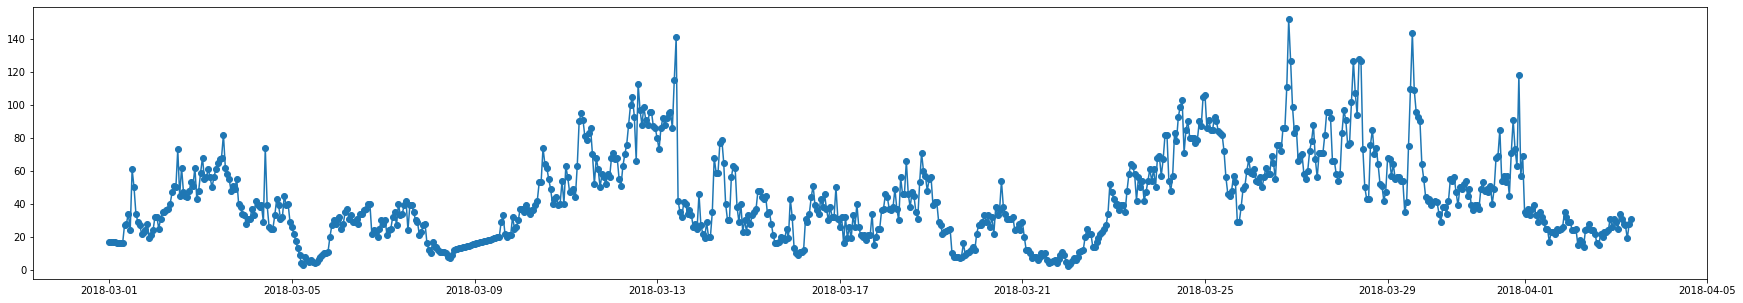

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(all_obs.loc[:800, 'Time'], all_obs.loc[:800, 'pm10'], '-o')

In [ ]:
# KNN이랑 Interpolate 비교...

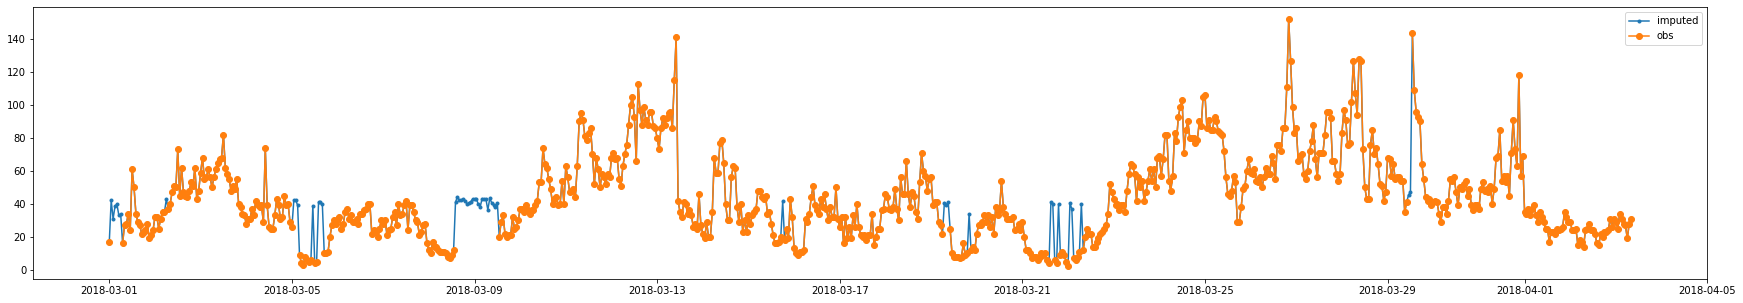
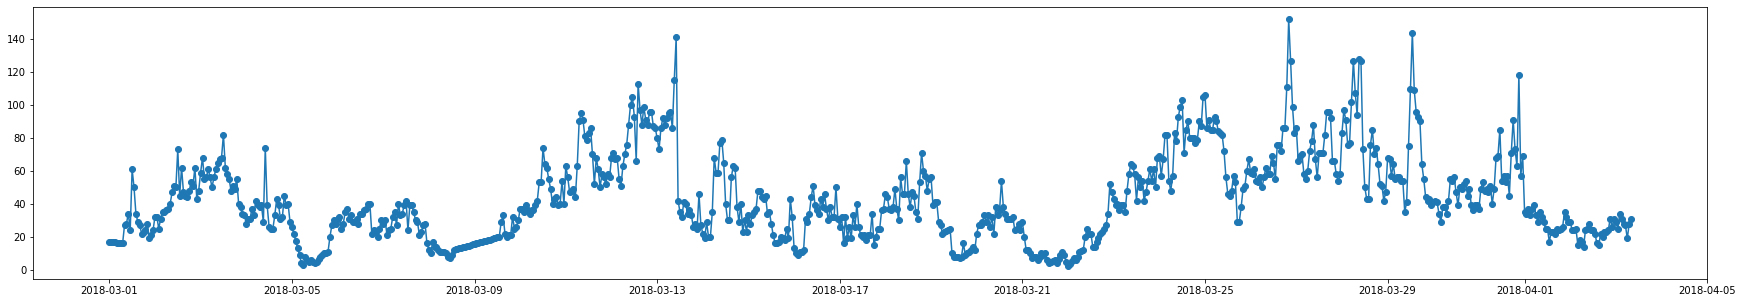

# 5 구름량 예측 모델

## 5_1 Linear Regression
- 13개 변수로 돌린후 backward elimination

#### 상관분석

In [ ]:
import seaborn as sns

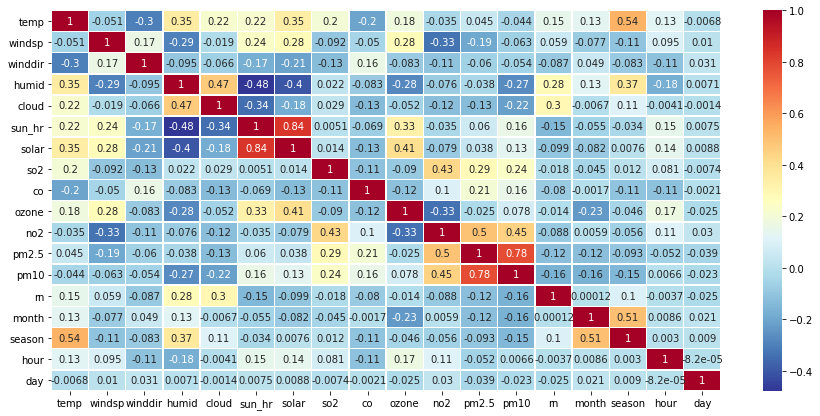

In [ ]:
all_obs_cc = all_obs.dropna(axis=0)  # complete case
corr = all_obs_cc.corr(method='pearson')
#corr.style.background_gradient(cmap='coolwarm')
fig, ax = plt.subplots( figsize=(15,7) )
sns.heatmap(corr, cmap='RdYlBu_r', annot = True, linewidths=.5)
plt.show()

In [ ]:
# # 잔차 정규성 확인
# def make_regression2(n_sample=100, bias=0, noise=0.3, random_state=0):
#     np.random.seed(random_state)
#     x = np.random.rand(n_sample) * 4
#     epsilon = noise * np.random.randn(n_sample)
#     y = x ** 2 + bias + epsilon
#     return x, y


# x2, y2 = make_regression2()
# plt.scatter(x2, y2)
# plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from sklearn import linear_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
slr = LinearRegression()
model_reg1 = slr.fit(x_train, y_train)
y_predict= slr.predict(x_test)

In [ ]:
model = sm.OLS()

In [ ]:
print('Coefficients: \n', slr.coef_)
print("RSS: %.2f" % np.mean((slr.predict(x_test) - y_test) ** 2))
print('Variance score: %.2f' % slr.score(x_test, y_test))

Coefficients: 
 [[0.892308   0.63861302 0.09285548]]
RSS: 0.11
Variance score: 0.27


In [ ]:
# slr = LinearRegression()
# model_reg1 = slr.fit(x, y)

In [ ]:
# print('Coefficients: \n',  model_reg1.coef_)  # coefficients
# print("RSS: %.2f" % mean_squared_error(model_reg1.predict(x2_test), y2_test)) # mean square error : 12.19
# print('R Squared: %.2f' % model_reg.score(x2_train, y2_train)) # 0.26
# print('Variance score: %.2f' % model_reg1.score(x2_test, y2_test)) # 0.23
# # OLS regression을 사용하겠음!

In [ ]:
# statsmodels.formula.api > ols 사용
# C(변수)로 categorical 변수 지정
reg_model1 = ols('cloud ~ C(season) + C(rn) + temp + windsp +winddir +humid +so2 +co +ozone +no2 +pm25 +pm10', data=df).fit()
reg_model1.summary()
# R-squard: 0.260 Adj. R-squared:	0.259 높지 않아서 좋지 않은 모델
# F-statistic:	471.8 ????

In [ ]:
reg_model2 = ols('cloud ~ C(season) + C(rn) + temp + windsp + winddir + humid', data=df).fit()
reg_model2.summary()

In [ ]:
model_reg1.predict(y2_test)

ValueError: ignored

## 5_2 RandomForest



In [ ]:
std_filled['cloud'] = all_obs['cloud']

In [ ]:
std_filled=all_obs[~all_obs['cloud'].isnull()]

In [ ]:
std_filled=std_filled[~std_filled['cloud'].isnull()]

,time,temp,windsp,winddir,humid,month,rn,co,sun_hr,solar,day,hour,so2,ozone,no2,pm2.5,pm10,cloud
0,2018-03-01 00:00:00,8.2,3.9,340.0,98.0,3,0.200000,2.2,0.0,0.0,1,0,-0.677494,0.833460,-0.449855,-0.832586,-0.875730,10.0
1,2018-03-01 01:00:00,7.0,4.1,320.0,97.0,3,0.191667,1.0,0.0,0.0,1,1,-0.677494,1.930621,-0.982214,-0.322680,-0.893835,10.0
3,2018-03-01 03:00:00,6.2,4.6,320.0,79.0,3,0.175000,0.3,0.0,0.0,1,3,-0.677494,2.253316,-1.286419,-0.960063,-0.792963,3.0
4,2018-03-01 04:00:00,6.7,4.5,320.0,73.0,3,0.166667,1.7,0.0,0.0,1,4,-0.677494,1.930621,-1.286419,-0.896324,-0.785204,1.0
5,2018-03-01 05:00:00,7.5,6.0,290.0,69.0,3,0.158333,0.4,0.0,0.0,1,5,-0.247229,1.930621,-1.286419,-0.960063,-0.800722,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25627,2021-01-31 19:00:00,8.8,2.5,200.0,50.0,1,0.000000,NaN,0.0,0.0,31,19,-0.096636,-0.044268,-0.409295,-0.705109,-0.389475,5.0
25628,2021-01-31 20:00:00,8.7,3.9,200.0,49.0,1,0.000000,NaN,0.0,0.0,31,20,-0.060781,-0.130320,-0.054389,-0.386418,-0.311881,1.0
25629,2021-01-31 21:00:00,8.4,2.4,230.0,51.0,1,0.000000,NaN,0.0,0.0,31,21,-0.039268,-0.005545,-0.059459,-0.195203,-0.001505,7.0
25630,2021-01-31 22:00:00,9.4,3.3,230.0,51.0,1,0.000000,NaN,0.0,0.0,31,22,-0.103807,-0.655237,0.224465,-0.258941,0.037292,8.0


In [ ]:
all_obs_cc

,time,temp,windsp,winddir,humid,cloud,sun_hr,solar,so2,co,ozone,no2,pm2.5,pm10,rn,month,season,hour,day
2,2018-03-01 02:00:00,6.5,5.9,290.0,80.0,NaN,0.0,0.00,0.003,0.8,0.057,0.009,8.0,NaN,0.183333,3,2,2,1
19,2018-03-01 19:00:00,5.6,1.2,200.0,18.0,NaN,0.1,0.01,0.003,1.5,0.059,0.012,17.0,23.0,0.041667,3,2,19,1
20,2018-03-01 20:00:00,4.7,0.9,20.0,20.0,NaN,0.0,0.00,0.002,0.9,0.059,0.012,20.0,24.0,0.033333,3,2,20,1
22,2018-03-01 22:00:00,2.9,4.8,290.0,32.0,NaN,0.0,0.00,0.003,0.5,0.057,0.010,16.0,19.0,0.016667,3,2,22,1
23,2018-03-01 23:00:00,2.1,4.4,320.0,35.0,NaN,0.0,0.00,0.002,0.3,0.057,0.008,19.0,21.0,0.008333,3,2,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21548,2020-08-14 20:00:00,29.3,2.9,200.0,83.0,NaN,0.0,0.00,0.020,0.9,0.016,0.041,35.0,58.0,0.000000,8,3,20,14
21884,2020-08-28 20:00:00,27.2,2.2,180.0,89.0,NaN,0.0,0.00,0.018,0.7,0.019,0.021,17.0,22.0,6.233333,8,3,20,28
22298,2020-09-15 02:00:00,19.0,1.1,340.0,98.0,NaN,0.0,0.00,0.003,0.9,0.011,NaN,32.0,40.0,0.400000,9,4,2,15
23758,2020-11-14 22:00:00,12.6,1.7,340.0,72.0,NaN,0.0,0.00,0.005,0.4,0.019,0.027,3.0,26.0,0.000000,11,4,22,14


In [ ]:
all_obs_cc = all_obs[all_obs['cloud'].isnull()]

In [ ]:
# # 정은님 rain 보간법 1차 co 빼기 계절빼기
y2 = all_obs_cc.loc[:,['cloud']]
x2 = all_obs_cc.loc[:,['temp', 'windsp', 'winddir', 'humid', 'sun_hr', 'solar', 'so2', 'co', 'ozone', 'no2', 'pm2.5', 'pm10', 'rn', 'month',  'season', 'hour', 'day']]
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, train_size=0.7, test_size=0.3)

In [ ]:
y2 = std_filled.loc[:,['cloud']]
x2 = std_filled.loc[:,['rn', 'month', 'temp', 'windsp',  'hour','day', 'solar','sun_hr', 'ozone', 'humid']]
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, train_size=0.7, test_size=0.3)

In [ ]:
all_obs_cc.shape

(825, 19)

In [ ]:
print(x2_test.shape,  y2_test.shape, x2_train.shape, y2_train.shape)

(248, 18) (248, 1) (577, 18) (577, 1)


In [ ]:
 # 학습 진행
forest = RandomForestRegressor(n_estimators=100, random_state=10 ,max_depth=12, min_samples_leaf= 8, min_samples_split= 8)
model = forest.fit(x2_train, y2_train)

# 예측
y_pred = forest.predict(x2_test)
print(y_pred)
print(list(y2_test))
#accuracy = accuracy_score(y2_test, y_pred)

# 정확도 확인
print(mean_squared_error(y2_test, y_pred))
print(forest.score(x2_test, y2_test))
#print(accuracy)

TypeError: ignored

In [ ]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestRegressor(random_state =10, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(x2_train, y2_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.5354


In [ ]:
from sklearn.metrics import classification_report 
print(classification_report(y2_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.89      0.64      1805
         1.0       0.17      0.03      0.05       216
         2.0       0.19      0.04      0.06       244
         3.0       0.29      0.07      0.11       276
         4.0       0.12      0.02      0.03       246
         5.0       0.13      0.03      0.04       259
         6.0       0.25      0.08      0.12       386
         7.0       0.23      0.14      0.17       529
         8.0       0.27      0.18      0.22       578
         9.0       0.36      0.25      0.29       585
        10.0       0.59      0.79      0.68      1261

    accuracy                           0.47      6385
   macro avg       0.28      0.23      0.22      6385
weighted avg       0.39      0.47      0.39      6385



#### 구름량 예측하기

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=12,random_state=2,max_features=4, min_samples_leaf= 8, min_samples_split= 8)
model.fit(x2_train, y2_train)
print(model.score(x2_train, y2_train))
print(model.score(x2_test, y2_test))

# ##########모델 예측

x_temp = all_obs[['cloud']] #na인것만 다시 가져올것
y_predict2 = model.predict(x_temp)

print("="*100)
pd.DataFrame(y_predict2).value_counts()


TypeError: ignored

In [ ]:
all_obs_cc = all_obs.dropna(axis=0)

### 특성 중요도

특성 중요도 : 
[0.36536116 0.03151556 0.0809072  0.0350528  0.02718907 0.05530311
 0.09242514 0.1633063  0.04371684 0.10522282]


ValueError: ignored

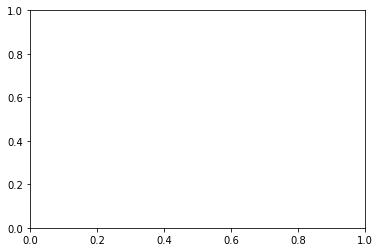

In [ ]:
print("특성 중요도 : \n{}".format(forest.feature_importances_))
feature_names = x2_train.columns.tolist()

def plot_feature_importances(model):

    n_features = x2_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_)

    plt.yticks(np.arange(n_features),feature_names)

    plt.xlabel("attr importances")

    plt.ylabel("attr")

plt.show()
plot_feature_importances(forest)